### 과제 1) 시애틀 날씨 LSTM 예측

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams['axes.unicode_minus']=False
plt.rc('font', family='AppleGothic')

In [2]:
df = pd.read_csv('seattle-weather.csv')

In [3]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [5]:
# 결측치 x, 범주형(weather), 날짜 데이터(date)

In [6]:
import datetime

df['date'] = pd.to_datetime(df['date'])
# 이미 날짜별 오름차순 정렬이 되어있다.

In [7]:
df.weather.unique()

array(['drizzle', 'rain', 'sun', 'snow', 'fog'], dtype=object)

In [8]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [9]:
df.weather.unique()

array(['drizzle', 'rain', 'sun', 'snow', 'fog'], dtype=object)

In [10]:
df.duplicated().sum() # 중복행 검사

0

In [11]:
df.isnull().sum() # 결측치 검사

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [12]:
# 날짜, 강수량, 최고온도, 최저온도, 풍속, 날씨

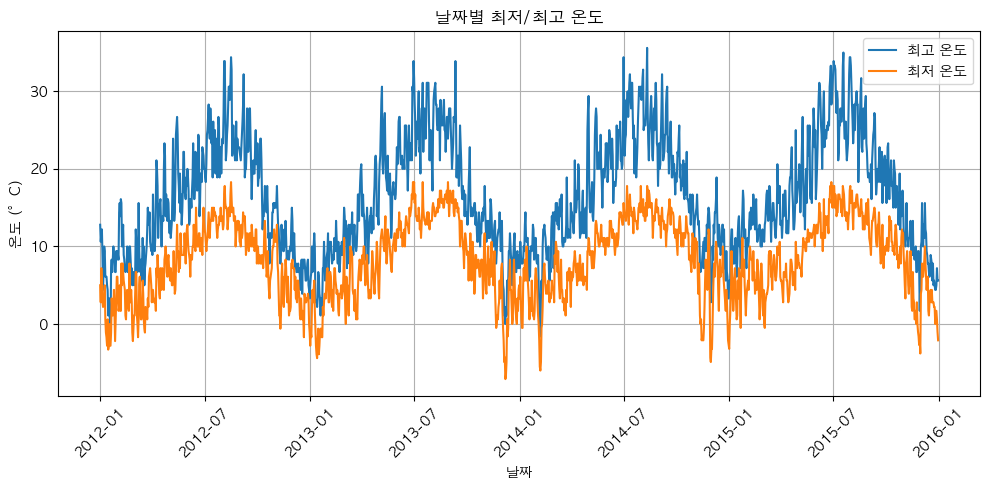

In [13]:
# 날짜별 최저/최고온도 그래프
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['temp_max'], linestyle='-', label='최고 온도')
plt.plot(df['date'], df['temp_min'], linestyle='-', label='최저 온도')
plt.title('날짜별 최저/최고 온도')
plt.xlabel('날짜')
plt.ylabel('온도 (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

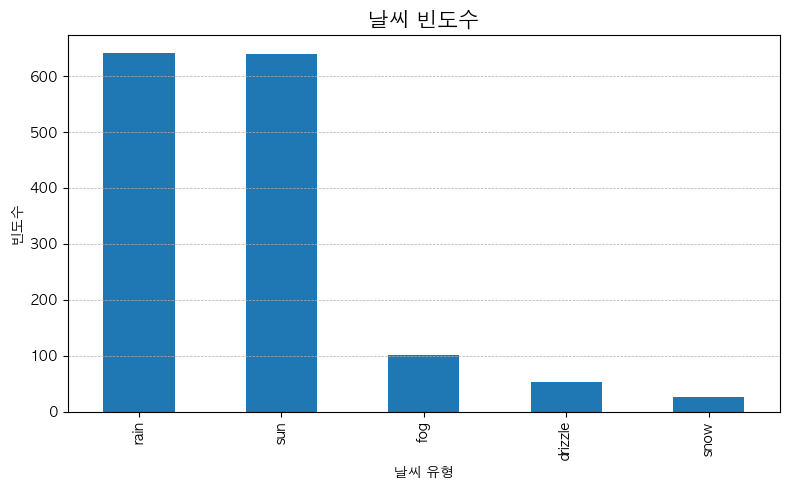

In [14]:
# 날씨 빈도수 그래프
plt.figure(figsize=(8, 5))
weather_counts = df['weather'].value_counts()
weather_counts.plot(kind='bar')
plt.title('날씨 빈도수', fontsize=15)
plt.xlabel('날씨 유형')
plt.ylabel('빈도수')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [15]:
scaler = MinMaxScaler()
scaler.fit(df.precipitation.values.reshape(-1, 1))

MinMaxScaler()

In [16]:
test_size = df[df.date.dt.year==2015].shape[0]
test_size

365

In [17]:
window_size = 60

In [18]:
train_data = df.precipitation[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [19]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i,0])

In [20]:
X_train

[array([0.        , 0.19499106, 0.01431127, 0.36314848, 0.02325581,
        0.04472272, 0.        , 0.        , 0.07692308, 0.01788909,
        0.        , 0.        , 0.        , 0.07334526, 0.09481216,
        0.04472272, 0.14490161, 0.35420394, 0.27191413, 0.24150268,
        0.05366726, 0.10912343, 0.        , 0.15384615, 0.14490161,
        0.08586762, 0.        , 0.        , 0.49552773, 0.06440072,
        0.03220036, 0.24150268, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00536673, 0.05008945, 0.04472272,
        0.04472272, 0.01431127, 0.01788909, 0.2039356 , 0.04472272,
        0.        , 0.03220036, 0.30948122, 0.11449016, 0.        ,
        0.05366726, 0.01431127, 0.15384615, 0.        , 0.2039356 ,
        0.        , 0.02325581, 0.        , 0.06440072, 0.01431127]),
 array([0.19499106, 0.01431127, 0.36314848, 0.02325581, 0.04472272,
        0.        , 0.        , 0.07692308, 0.01788909, 0.        ,
        0.        , 0.        , 0.07334526, 0.

In [21]:
test_data = df.precipitation[-test_size-60:] # -test_size-window_size
test_data = scaler.transform(test_data.values.reshape(-1, 1))

In [22]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i,0])

In [23]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [24]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [25]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1036, 60, 1) (365, 60, 1)
(1036, 1) (365, 1)


In [26]:
def define_model():
    inputs = Input(shape=(window_size, 1))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    return model

In [27]:
model = define_model()
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split = 0.1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

In [28]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

12/12 [==============================] - 1s 13ms/step


In [29]:
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 1 - mape

In [30]:
print('Test Loss : ', result)
print('test MAPE : ', mape)
print('Test Accuracy : ', accuracy)

Test Loss :  0.01642424240708351
test MAPE :  134512711423826.98
Test Accuracy :  -134512711423825.98


In [31]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)
train_data_true = scaler.inverse_transform(train_data)

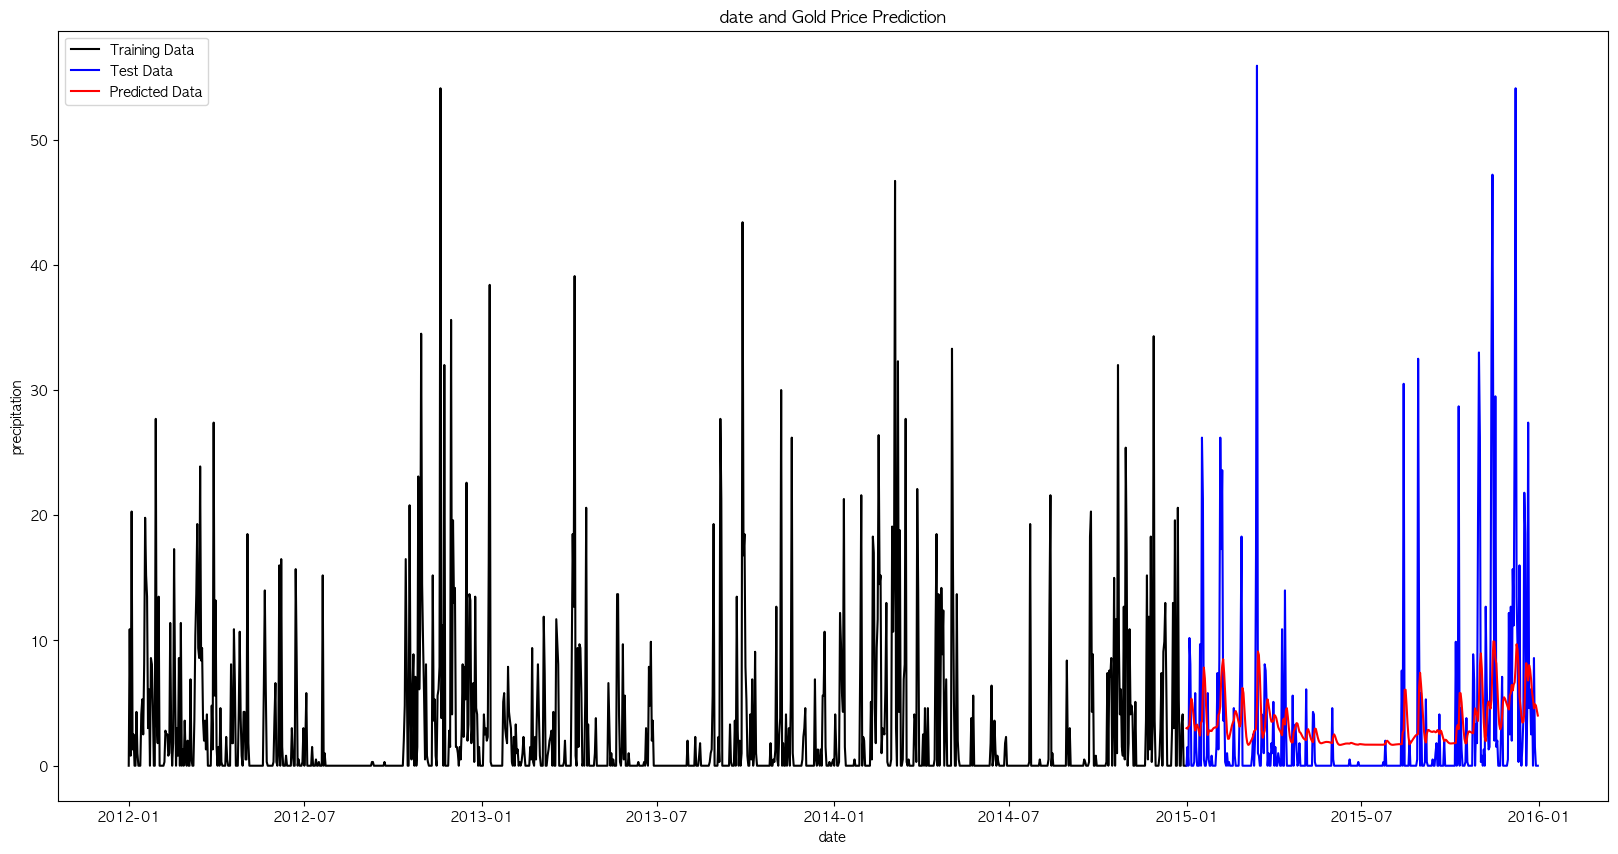

In [32]:
plt.figure(figsize=(20,10))
plt.plot(df['date'].iloc[:-test_size], train_data_true, color='black')
plt.plot(df['date'].iloc[-test_size:], y_test_true, color='blue')
plt.plot(df['date'].iloc[-test_size:], y_test_pred, color='red')
plt.title('date and Gold Price Prediction')
plt.xlabel('date')
plt.ylabel('precipitation')
plt.legend(['Training Data', 'Test Data', 'Predicted Data'])
plt.show()

### 숙제 2 : REAL, FAKE NEWS - GloVe

In [18]:
import pandas as pd

fake_news_df = pd.read_csv('Fake.csv')
real_news_df = pd.read_csv('True.csv')

In [19]:
fake_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [20]:
real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [21]:
fake_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [22]:
real_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [23]:
fake_news_df['combined'] = fake_news_df['title'] + " " + fake_news_df['text']
real_news_df['combined'] = real_news_df['title'] + " " + real_news_df['text']

print("Combined Fake News Text:\n", fake_news_df['combined'].head())
print("\nCombined Real News Text:\n", real_news_df['combined'].head())

Combined Fake News Text:
 0     Donald Trump Sends Out Embarrassing New Year’...
1     Drunk Bragging Trump Staffer Started Russian ...
2     Sheriff David Clarke Becomes An Internet Joke...
3     Trump Is So Obsessed He Even Has Obama’s Name...
4     Pope Francis Just Called Out Donald Trump Dur...
Name: combined, dtype: object

Combined Real News Text:
 0    As U.S. budget fight looms, Republicans flip t...
1    U.S. military to accept transgender recruits o...
2    Senior U.S. Republican senator: 'Let Mr. Muell...
3    FBI Russia probe helped by Australian diplomat...
4    Trump wants Postal Service to charge 'much mor...
Name: combined, dtype: object


In [24]:
import numpy as np

glove_file_path = 'glove.6B.100d.txt'

def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_glove_embeddings(glove_file_path)
print(f"Loaded {len(embeddings_index)} word vectors.")

Loaded 400000 word vectors.


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

texts = pd.concat([real_news_df['combined'], fake_news_df['combined']], axis=0).values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences)

embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

def get_text_embedding(text):
    words = text.split()
    word_vectors = [embeddings_index.get(word) for word in words if word in embeddings_index]
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)
    return np.mean(word_vectors, axis=0)

real_embeddings = np.array([get_text_embedding(text) for text in real_news_df['combined'].values])
fake_embeddings = np.array([get_text_embedding(text) for text in fake_news_df['combined'].values])

print("Real News Embeddings Shape:", real_embeddings.shape)
print("Fake News Embeddings Shape:", fake_embeddings.shape)

Real News Embeddings Shape: (21417, 100)
Fake News Embeddings Shape: (23481, 100)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_pca(real_embeddings, fake_embeddings, alpha=0.5):
    pca = PCA(n_components=2)
    real_pca = pca.fit_transform(real_embeddings)
    fake_pca = pca.fit_transform(fake_embeddings)

    plt.figure(figsize=(10, 6))
    plt.scatter(real_pca[:, 0], real_pca[:, 1], c='blue', label='Real News', alpha=alpha)
    plt.scatter(fake_pca[:, 0], fake_pca[:, 1], c='red', label='Fake News', alpha=alpha)
    plt.title('PCA of News Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

plot_pca(real_embeddings, fake_embeddings, alpha=0.5)

def plot_tsne(real_embeddings, fake_embeddings, alpha=0.5):
    tsne = TSNE(n_components=2, random_state=42)
    real_tsne = tsne.fit_transform(real_embeddings)
    fake_tsne = tsne.fit_transform(fake_embeddings)

    plt.figure(figsize=(10, 6))
    plt.scatter(real_tsne[:, 0], real_tsne[:, 1], c='blue', label='Real News', alpha=alpha)
    plt.scatter(fake_tsne[:, 0], fake_tsne[:, 1], c='red', label='Fake News', alpha=alpha)
    plt.title('t-SNE of News Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

plot_tsne(real_embeddings, fake_embeddings, alpha=0.5)

In [29]:
# 강사님 코드

In [30]:
# 시애틀 날씨 LSTM 예측

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings(action='ignore')

In [35]:
df = pd.read_csv('seattle-weather.csv')

In [36]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [39]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [41]:
df.duplicated().sum()

0

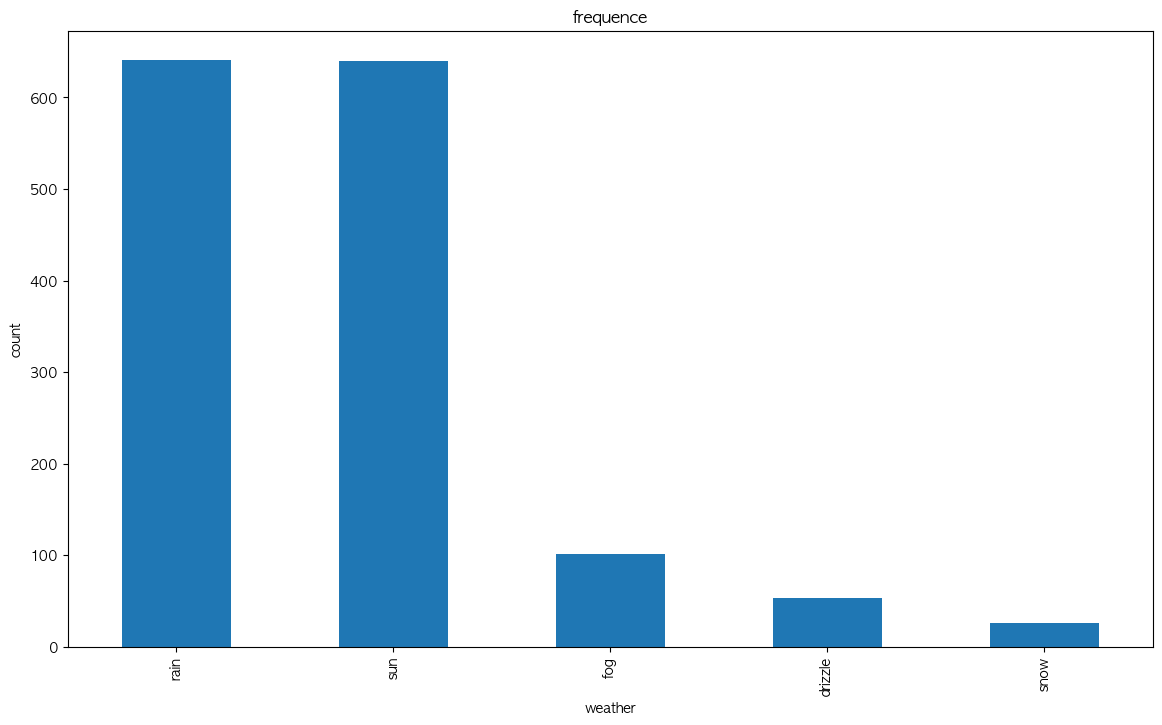

In [42]:
plt.figure(figsize=(14, 8))
weather_counts = df['weather'].value_counts()
weather_counts.plot(kind='bar')
plt.title('frequence')
plt.xlabel('weather')
plt.ylabel('count')
plt.show()

In [43]:
training_set = df.iloc[:, 2:3].values
training_set

array([[12.8],
       [10.6],
       [11.7],
       ...,
       [ 7.2],
       [ 5.6],
       [ 5.6]])

In [44]:
len(training_set)

1461

In [46]:
def df_to_XY(df, window_size=10):
    X_train=[]
    y_train=[]

    for i in range(10, len(training_set)):
        X_train.append(training_set[i-10:i, 0])
        y_train.append(training_set[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

In [47]:
X, y = df_to_XY(df)
print(len(X), len(y))

1451 1451


In [48]:
X

array([[12.8, 10.6, 11.7, ..., 10. ,  9.4,  6.1],
       [10.6, 11.7, 12.2, ...,  9.4,  6.1,  6.1],
       [11.7, 12.2,  8.9, ...,  6.1,  6.1,  6.1],
       ...,
       [ 8.3,  7.8,  5.6, ...,  4.4,  4.4,  5. ],
       [ 7.8,  5.6,  7.8, ...,  4.4,  5. ,  7.2],
       [ 5.6,  7.8,  5. , ...,  5. ,  7.2,  5.6]])

In [49]:
y

array([6.1, 6.1, 5. , ..., 7.2, 5.6, 5.6])

In [50]:
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
y_test = y[1000:]

In [51]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [52]:
X_train

array([[[12.8],
        [10.6],
        [11.7],
        ...,
        [10. ],
        [ 9.4],
        [ 6.1]],

       [[10.6],
        [11.7],
        [12.2],
        ...,
        [ 9.4],
        [ 6.1],
        [ 6.1]],

       [[11.7],
        [12.2],
        [ 8.9],
        ...,
        [ 6.1],
        [ 6.1],
        [ 6.1]],

       ...,

       [[12.8],
        [15. ],
        [12.2],
        ...,
        [16.7],
        [10.6],
        [10. ]],

       [[15. ],
        [12.2],
        [14.4],
        ...,
        [10.6],
        [10. ],
        [10. ]],

       [[12.2],
        [14.4],
        [16.1],
        ...,
        [10. ],
        [10. ],
        [11.1]]])

In [56]:
model = Sequential()

model.add(LSTM(units=50, return_sequences = True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [57]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
25/25 [==============================] - 3s 37ms/step - loss: 212.1106 - val_loss: 256.2247
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 91.6452 - val_loss: 153.7402
Epoch 3/100
25/25 [==============================] - 0s 11ms/step - loss: 67.6803 - val_loss: 121.3626
Epoch 4/100
25/25 [==============================] - 0s 11ms/step - loss: 59.6128 - val_loss: 104.8227
Epoch 5/100
25/25 [==============================] - 0s 12ms/step - loss: 57.4874 - val_loss: 94.2499
Epoch 6/100
25/25 [==============================] - 0s 11ms/step - loss: 54.5158 - val_loss: 87.3664
Epoch 7/100
25/25 [==============================] - 0s 11ms/step - loss: 54.4221 - val_loss: 83.1117
Epoch 8/100
25/25 [==============================] - 0s 12ms/step - loss: 55.5629 - val_loss: 80.0414
Epoch 9/100
25/25 [==============================] - 0s 12ms/step - loss: 55.5487 - val_loss: 78.6220
Epoch 10/100
25/25 [==============================] - 0s 12ms/step - loss: 53

In [58]:
history = pd.DataFrame(history.history)

In [59]:
history.head()

,loss,val_loss
0,212.110641,256.224731
1,91.645203,153.740234
2,67.680275,121.362625
3,59.612774,104.822685
4,57.487389,94.249901


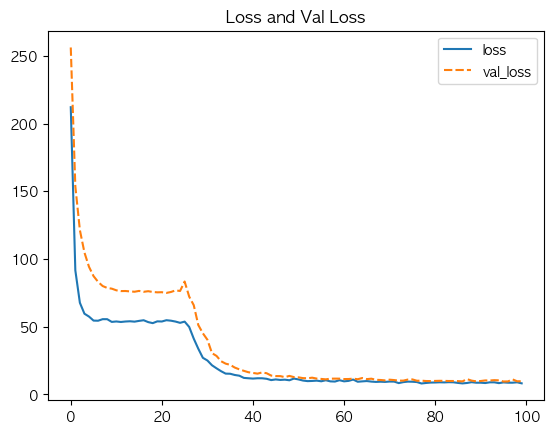

In [60]:
import seaborn as sns

history_loss = history[['loss', 'val_loss']]

sns.lineplot(history_loss)
plt.title('Loss and Val Loss')
plt.show()

In [61]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

15/15 [==============================] - 0s 5ms/step


In [62]:
print(len(train_pred), len(val_pred), len(test_pred))

800 200 451


In [64]:
pred = np.concatenate([train_pred, val_pred, test_pred])
print(len(pred))

1451


In [65]:
WINDOW = 10

df_pred = pd.DataFrame(df['temp_max'].copy())
df_pred.columns=['actual']
df_pred = df_pred[WINDOW:]
df_pred['predicted'] = pred

In [66]:
df_pred.head()

,actual,predicted
10,6.1,6.331560
11,6.1,6.236065
12,5.0,6.081309
13,4.4,5.368617
14,1.1,4.404113


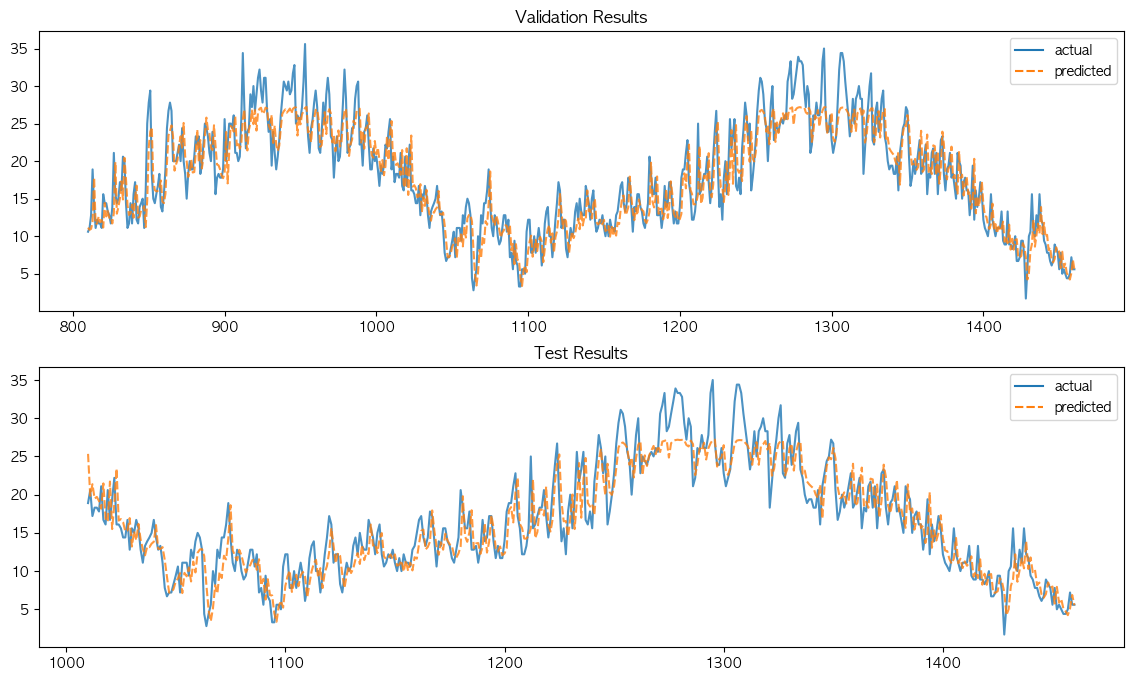

In [67]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.title('Validation Results')
sns.lineplot(df_pred[800:], alpha=0.8)

plt.subplot(2, 1, 2)
plt.title('Test Results')
sns.lineplot(df_pred[1000:], alpha=0.8)

plt.show()

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re, string
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [2]:
true = pd.read_csv('True.csv')
false = pd.read_csv('Fake.csv')

In [3]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true['category'] = 1
false['category'] = 0

In [6]:
true.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [7]:
false.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [8]:
df = pd.concat([true, false])
df

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [9]:
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [10]:
df.isnull().sum()





title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [11]:
df.title.count()

44898

In [12]:
df.subject.value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

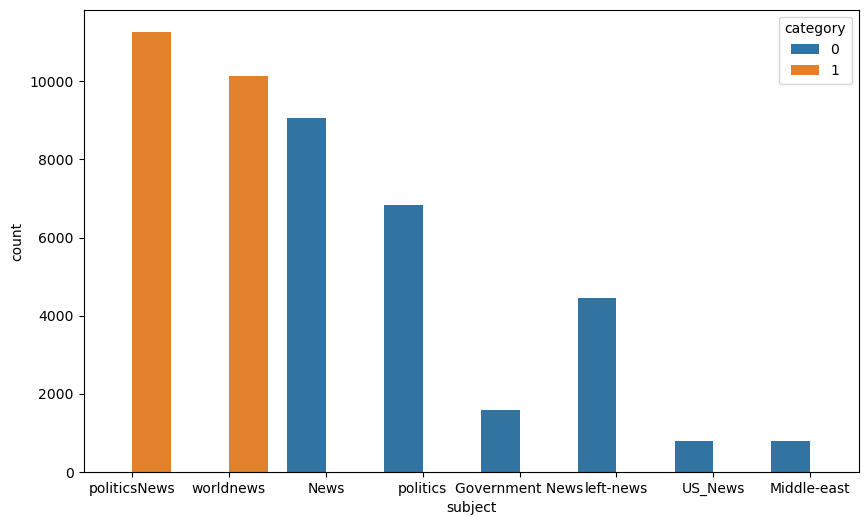

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', data=df, hue='category')
plt.show()

In [14]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [15]:
df.head()

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [16]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [17]:
def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())

    return ' '.join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [18]:
df['text'] = df['text'].apply(denoise_text)

/var/folders/mr/zpw8mcz14pj_gkyqs4k_zl4c0000gn/T/ipykernel_1544/3654366348.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [19]:
import warnings
warnings.filterwarnings(action='ignore')

In [20]:
df.head()

,text,category
0,WASHINGTON (Reuters) head conservative Republi...,1
1,WASHINGTON (Reuters) Transgender people allowe...,1
2,WASHINGTON (Reuters) special counsel investiga...,1
3,WASHINGTON (Reuters) Trump campaign adviser Ge...,1
4,SEATTLE/WASHINGTON (Reuters) President Donald ...,1


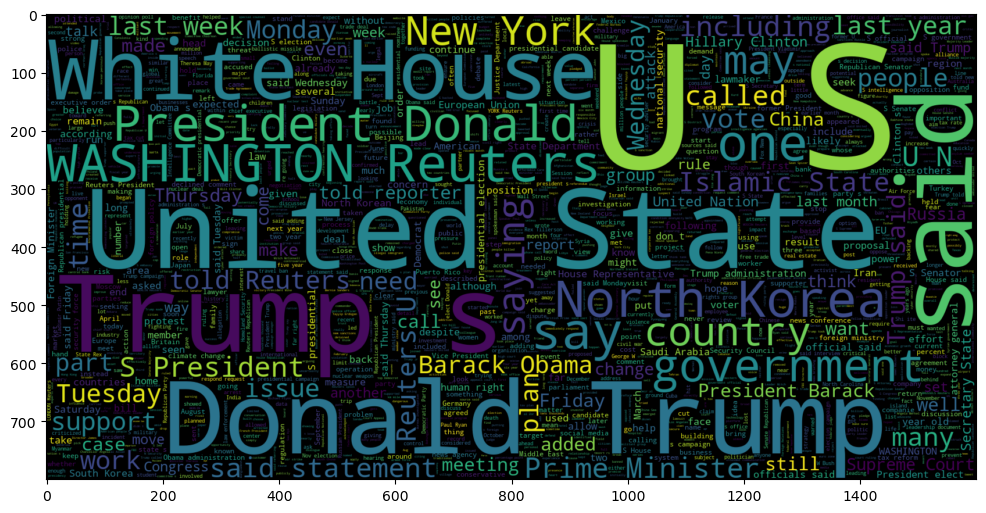

In [21]:
plt.figure(figsize=(12, 12))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df[df.category==1].text))
plt.imshow(wc, interpolation='bilinear')

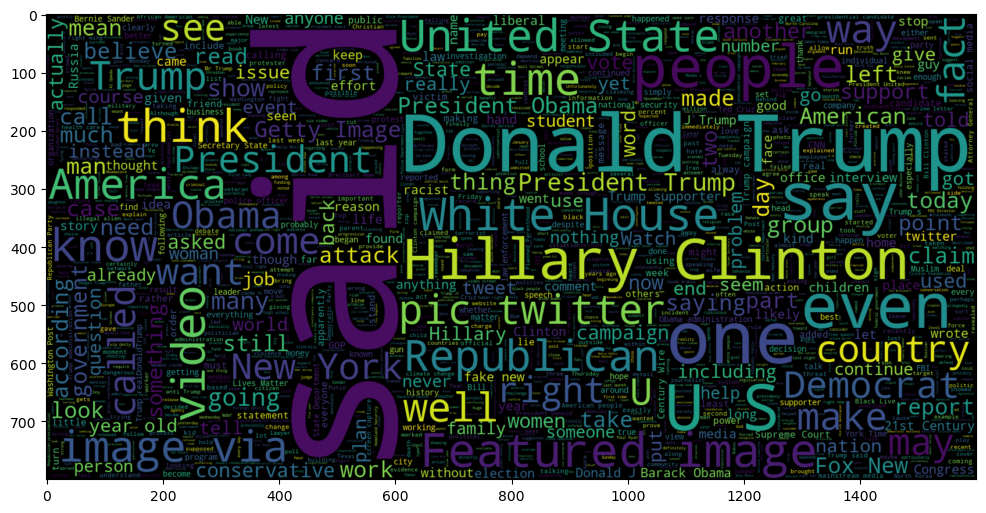

In [22]:
plt.figure(figsize=(12, 12))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df[df.category==0].text))
plt.imshow(wc, interpolation='bilinear')

In [23]:
# 길이 분석

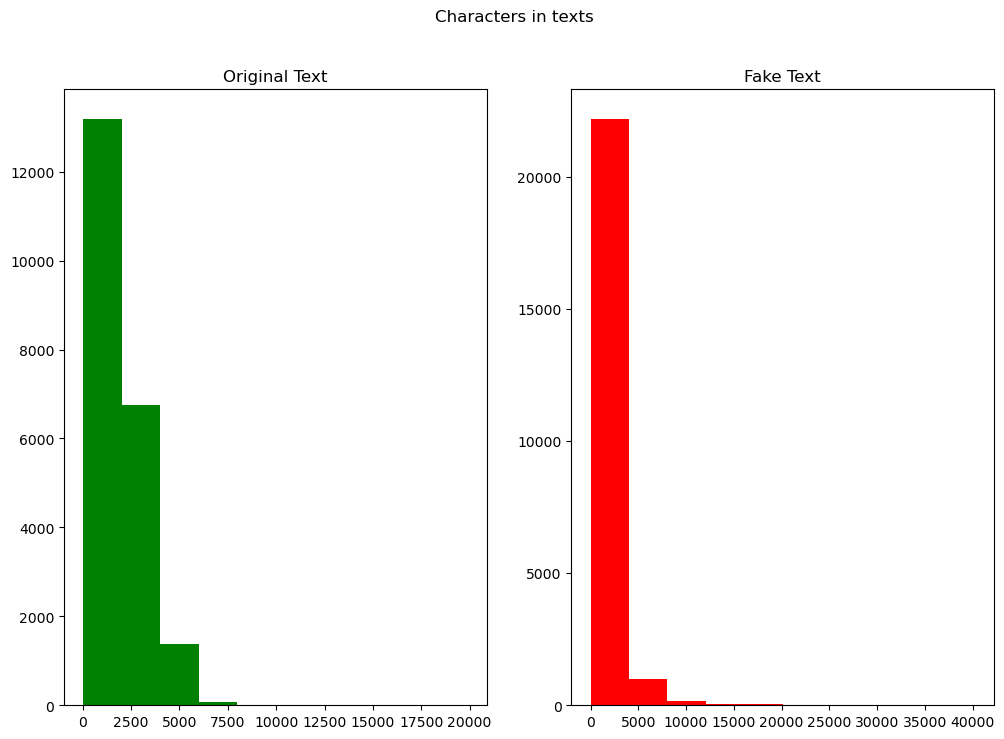

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
text_len = df[df['category']==1]['text'].str.len()
ax1.hist(text_len, color='green')
ax1.set_title('Original Text')

text_len = df[df['category']==0]['text'].str.len()
ax2.hist(text_len, color='red')
ax2.set_title('Fake Text')

fig.suptitle('Characters in texts')
plt.show()

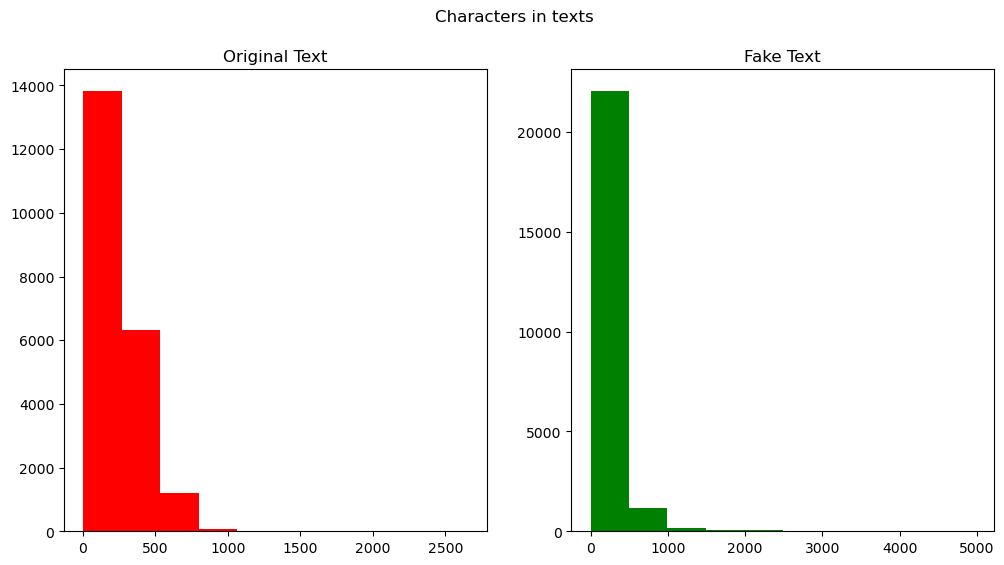

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
text_len = df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Original Text')

text_len = df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len, color='green')
ax2.set_title('Fake Text')

fig.suptitle('Characters in texts')
plt.show()

In [26]:
# 단어의 평균 길이

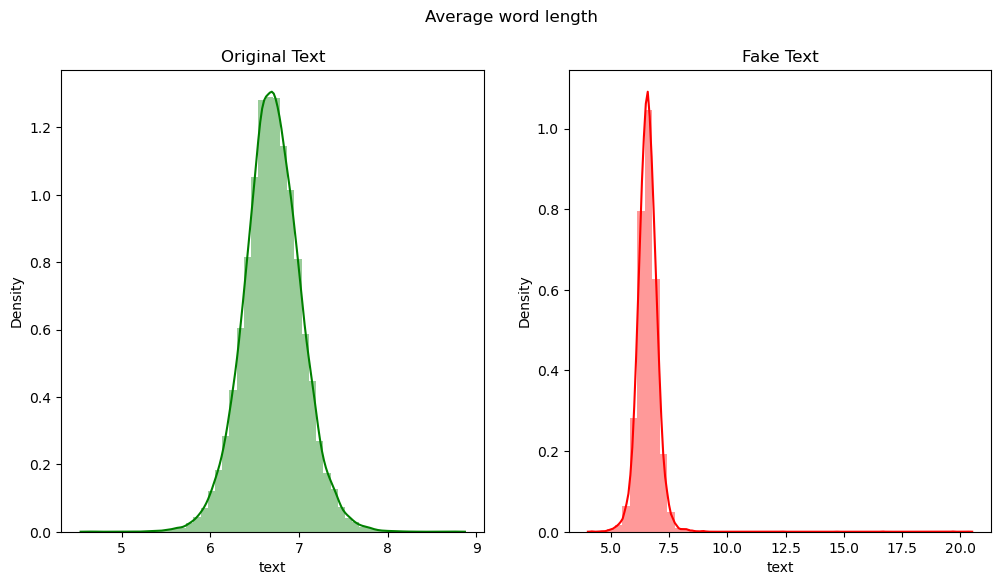

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
word = df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x : np.mean(x)), ax=ax1, color='green')
ax1.set_title('Original Text')

word = df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x : np.mean(x)), ax=ax2, color='red')
ax2.set_title('Fake Text')
fig.suptitle('Average word length')
plt.show()

In [28]:
# 토큰화
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words

corpus = get_corpus(df.text)
print(corpus[:20])

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican', 'faction', 'U.S.', 'Congress,', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'pay', 'tax', 'cuts,', 'called', '“fiscal', 'conservative”']


In [29]:
from collections import Counter

counter = Counter(corpus)
most_common = counter.most_common(10)
dict(most_common)

{'Trump': 111503,
 'said': 93162,
 'would': 54613,
 'U.S.': 50441,
 'President': 33180,
 'people': 33115,
 'also': 30325,
 'one': 29370,
 'Donald': 27795,
 'said.': 26194}

In [30]:
# n개의 단어를 가지고 그래프 제작

In [31]:
# Vectorizer : AI 모델에 입력으로 사용할 수 있는 숫자형 특징 벡터를 생성
# CountVectorizer : 텍스트 데이터를 단어 빈도수를 나타내는 벡터로 변환
# TfidfVectorizer : 빈도수와 역문서 빈도수를 결합하여 특징 벡터로 생성
# Word2Vec, Doc2Vec : 단어 또는 문서를 밀집 벡터(dense vector)로 생성

from sklearn.feature_extraction.text import CountVectorizer

def get_top_text_ngrams(corpus, n, g): # n : 상위 몇 개, g : n-gram(단어 몇 개를 연결)
    vec = CountVectorizer(ngram_range = (g, g)).fit(corpus) # ngram_range = (g, g) : g-그램(g 길이의 n-gram)을 생성, fit : corpus를 학습
    bag_of_words = vec.transform(corpus) # corpus를 vec의 n-gram의 출현 빈도수를 가진 행렬로 반환
    sum_words = bag_of_words.sum(axis=0) # 빈도수의 합계
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] # 단어, 빈도수 리스트
    words_freq = sorted(words_freq, key=lambda x : x[1], reverse=True) # 내림차순 정렬
    return words_freq[:n] # 상위 n 개의 g-gram 리스트 반환

<Axes: >

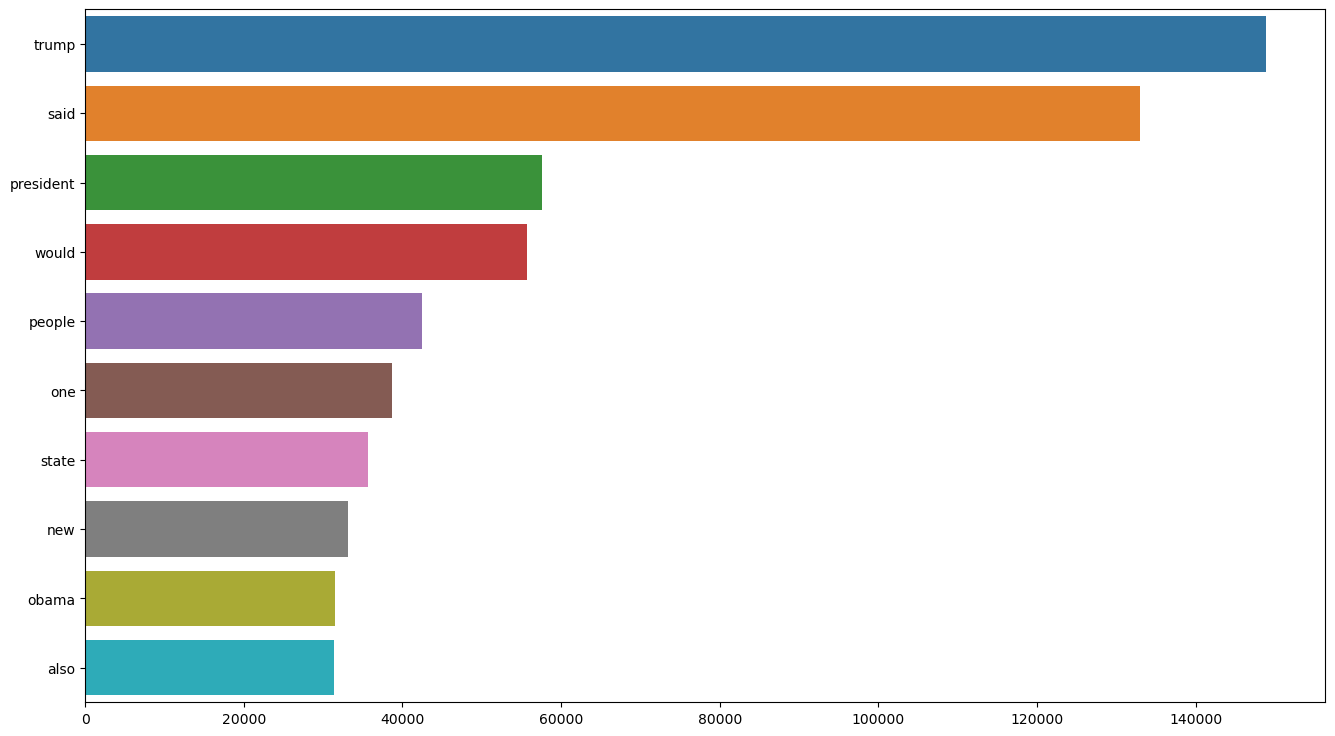

In [32]:
plt.figure(figsize=(16, 9))
most_common_uni = get_top_text_ngrams(df.text, 10, 1) # 1 - unigram
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()), y = list(most_common_uni.keys()))

<Axes: >

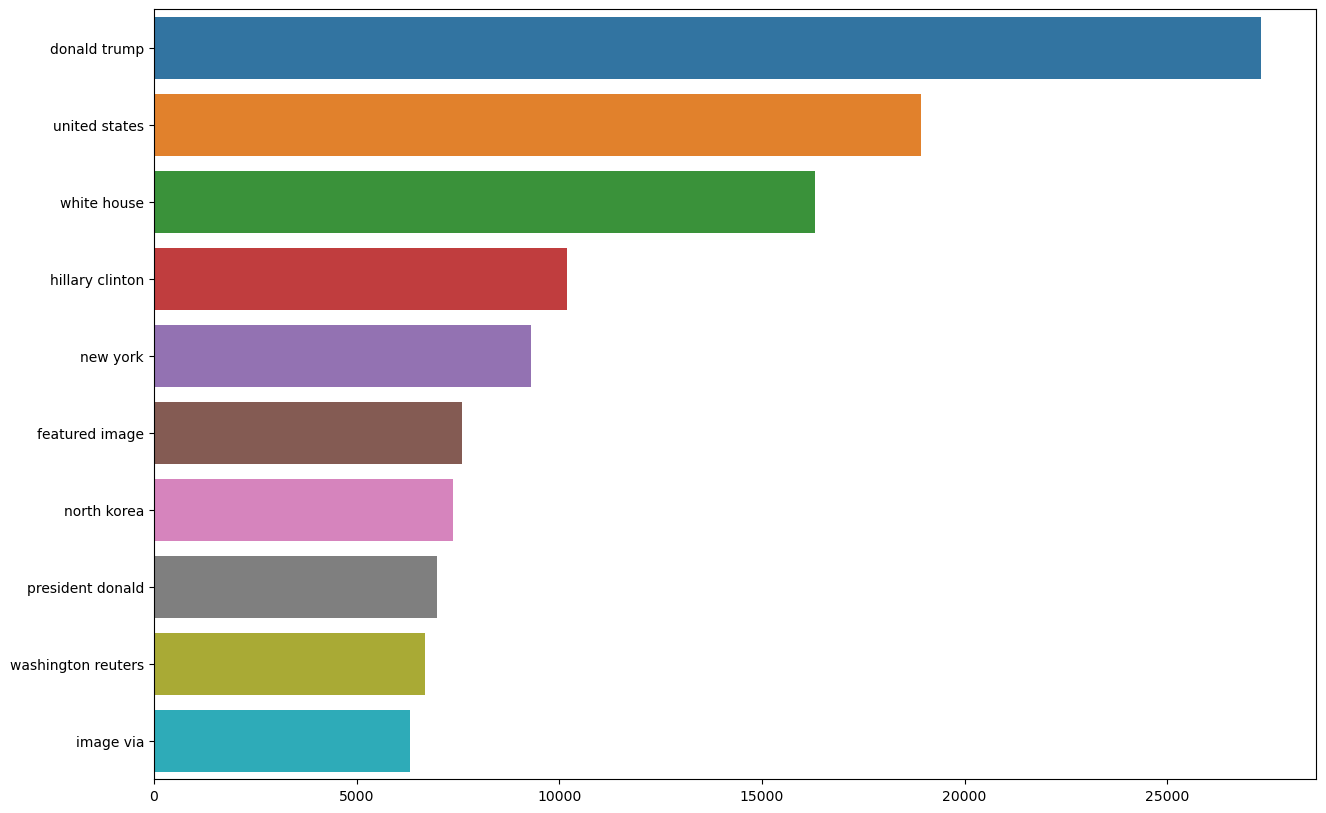

In [33]:
plt.figure(figsize=(15, 10))
most_common_bi = get_top_text_ngrams(df.text, 10, 2) # bigram
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()), y=list(most_common_bi.keys()))

<Axes: >

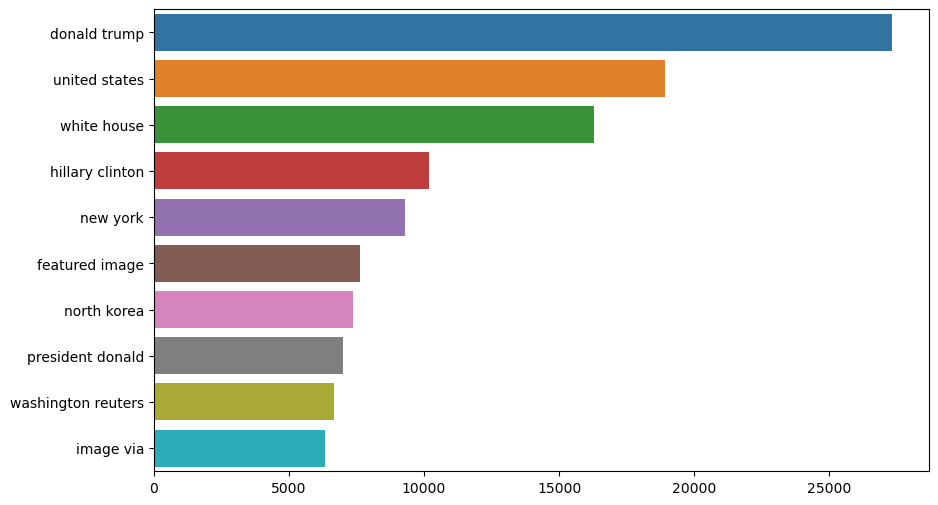

In [34]:
plt.figure(figsize=(10,6))
most_common_tri = get_top_text_ngrams(df.text, 10, 2) # trigram
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()), y=list(most_common_tri.keys()))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.category, random_state=42)

In [36]:
max_features=10000
maxlen=300

In [37]:
from tensorflow.keras.preprocessing import text

tokenizer = text.Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_train, maxlen=maxlen)

In [38]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [39]:
EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'

In [42]:
def get_coefs(word, *arr): # 단어, 임베딩 값을 전달받아 튜플 형태로 반환
    return word, np.asarray(arr, dtype='float32')

with open(EMBEDDING_FILE, 'r', encoding='utf-8')as f:
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in f)

In [47]:
import numpy as np
all_embs = np.stack(list(embeddings_index.values())) # 모든 임베딩 값
emb_mean = all_embs.mean()
emb_std = all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index # 단어와 인덱스가 들어있는 딕셔너리
nb_words = min(max_features, len(word_index)) # 사용할 단어 수
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) # 정규 분포로 초기화된 임베딩 매트릭스(크기 :(nb_words, embed_size))

for word, i in word_index.items():
    if i>= max_features : # 인덱스가 max_features 이상이면 생략
        continue

    embedding_vector = embeddings_index.get(word) # 단어에 대한 임베딩 벡터

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [48]:
print(emb_mean, emb_std, embed_size)

0.009065018 0.4428109 200


In [49]:
print(max_features, len(word_index))
print(embedding_matrix)

10000 126330
[[-0.73716252 -0.82123072  0.47085452 ... -0.07350913  0.68209074
   0.26403486]
 [ 0.021029    0.28791001 -0.079057   ...  0.77636999 -0.45524001
  -0.68147999]
 [ 0.10802     0.12285    -0.050741   ...  0.40630999 -0.026206
  -0.10119   ]
 ...
 [-0.78386003  0.42081001 -0.24800999 ...  0.28909999 -0.024789
   0.39318001]
 [-0.73078001 -0.36939001 -0.50962001 ...  0.50654    -0.38589999
  -0.48367   ]
 [-0.13688     0.077095    0.14207999 ... -0.070936    0.038953
  -0.82964998]]


In [50]:
batch_size = 256
epochs = 2
embed_size = 200

In [51]:
import keras

model = Sequential()

# Embedding Layer : 텍스트 데이터를 벡터로 변환하여 사용하기 위함.
# trainable : False - 임베딩 레이어가 훈련되지 않도록 설정한다. (사전에 훈련된 임베딩을 그대로 사용)
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# LSTM : 시퀸스 데이터를 처리하기 위함. 첫번째 LSTM에서는 전체 타입스텝 출력, 두번째 LSTM 마지막 타입의 출력을 반환
model.add(LSTM(units=128, return_sequences = True, recurrent_dropout = 0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout = 0.1, dropout = 0.1))

# LSTM 이후 출력 차원 줄이기, 비선형성 추가
model.add(Dense(units=32, activation='relu'))

# 이진 분류 처리를 위한 sigmoid
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])          

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          2000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2219969 (8.47 MB)
Trainable params: 219969 (859.25 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________________________________________________________


In [53]:
history = model.fit(X_train, y_train, batch_size=batch_size, validation_data = (X_test, y_test), epochs = 2)

Epoch 1/2
132/132 [==============================] - 452s 3s/step - loss: 0.1422 - accuracy: 0.9385 - val_loss: 0.0360 - val_accuracy: 0.9893
Epoch 2/2
132/132 [==============================] - 391s 3s/step - loss: 0.0249 - accuracy: 0.9925 - val_loss: 0.0071 - val_accuracy: 0.9974


In [54]:
print('Training Accuracy : ', model.evaluate(X_train, y_train)[1]*100, '%')
print('Testing Accuracy : ', model.evaluate(X_test, y_test)[1]*100, '%')

1053/1053 [==============================] - 166s 158ms/step - loss: 0.0051 - accuracy: 0.9983
Training Accuracy :  99.83369708061218 %
351/351 [==============================] - 55s 158ms/step - loss: 0.0071 - accuracy: 0.9974
Testing Accuracy :  99.74164962768555 %


Text(0, 0.5, 'Loss')

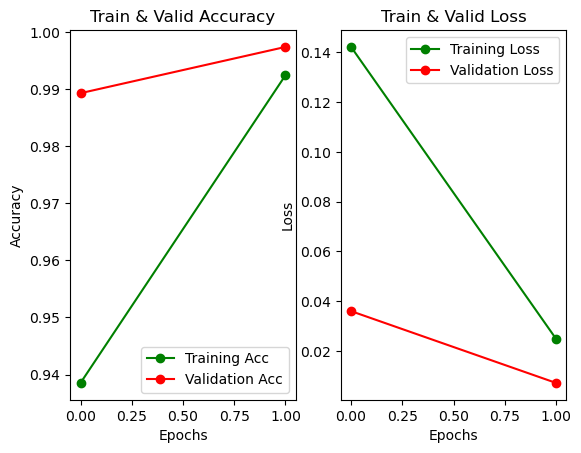

In [55]:
epochs = [i for i in range(2)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, 'go-', label='Training Acc')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Acc')
ax[0].set_title('Train & Valid Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
ax[1].set_title('Train & Valid Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

In [56]:
pred = model.predict(X_test)

351/351 [==============================] - 51s 144ms/step


In [57]:
pred[:5]

array([[2.1772162e-04],
       [1.0452883e-04],
       [1.6859054e-04],
       [9.9994367e-01],
       [2.7107706e-04]], dtype=float32)

In [58]:
binary_predictions = (pred >= 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [59]:
print(classification_report(y_test, binary_predictions, target_names = ['Fake', 'Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5829
    Not Fake       1.00      1.00      1.00      5396

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [60]:
cm = confusion_matrix(y_test, binary_predictions)
cm

array([[5815,   14],
       [  15, 5381]])

In [61]:
cm = pd.DataFrame(cm, index = ['Fake', 'Original'], columns = ['Fake', 'Original'])
cm

,Fake,Original
Fake,5815,14
Original,15,5381


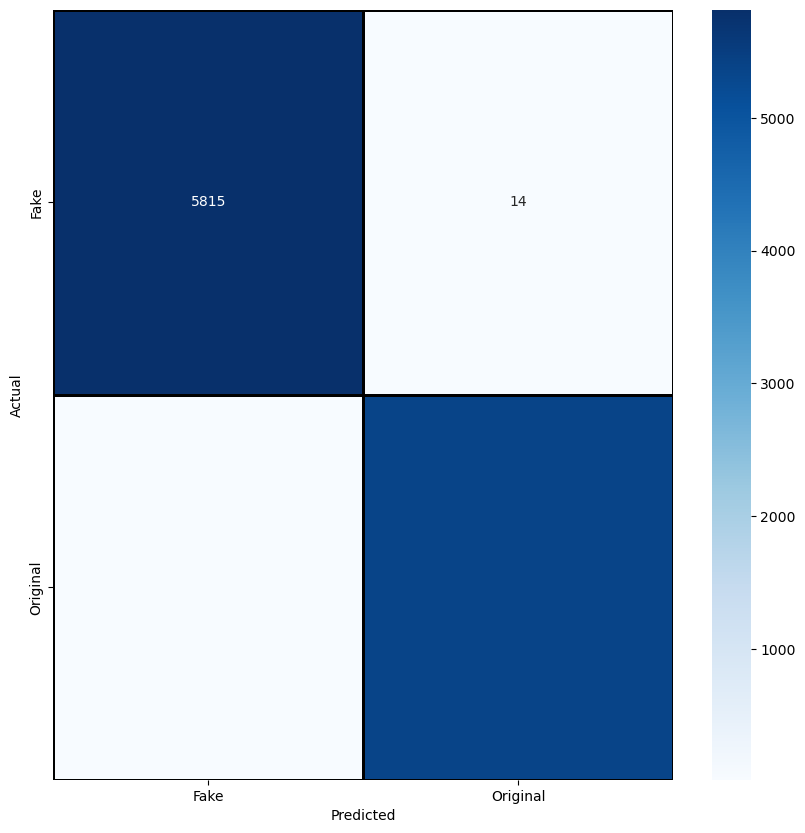

In [62]:
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap='Blues', linecolor='black', linewidth = 1, annot = True, fmt='', 
            xticklabels = ['Fake', 'Original'], yticklabels = ['Fake', 'Original'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()